### Data analysis with Scikit-learn and astroML (cont.)

scikit-learn is a set of general machine learning libraries written in Python

`pip install -U scikit-learn`

`conda install scikit-learn`

astroML is a set of machine Learning libraries written in Python aimed at astronomical problems

`pip install --pre --upgrade astroML`

They provide opensource, simple and efficient tools to use (they dont always scale to very large data sets). They are built on Numpy, Astropy, SciPy, and matplotlib and have similar interfaces so you can learn one routine and understand how to call many of the other packages

### Classification

In density estimation we estimate the
probability distributions from multivariate data sets to identify
the inherent clustering. This is <u> unsupervised classification </u>

If we have labels for some of these data points
(e.g., an object is tall, short, red, or blue) we can develop a relationship between the label and the
properties of a source. This is <u> supervised classification </u>

Classification, regression, and density
estimation are all related.  

### Classification loss

How do we measure how well our classification is doing?

We can define something called a _loss function_. A zero-one loss function assigns a value of one for a misclassification and zero for a correct classification (i.e. we will want to minimize the loss).

If $\hat{y}$ is the best guess value of $y$ the
classification loss, $L(y,\widehat{y})$, is

$L(y,\widehat{y}) = \delta(y \neq \widehat{y})$

which means

$\begin{eqnarray}
L(y,\hat{y}) & = & \left\{ \begin{array}{cl}
       	           1 & \mbox{if $y\neq\hat{y}$}, \\
       	           0 & \mbox{otherwise.}
       	           \end{array}
       	   \right.
\end{eqnarray}$

We can also  define the fraction of true and false classifications

$ {\rm completeness} = \frac{\rm true\ positives}
  {\rm true\ positives + false\ negatives},
$

$  {\rm contamination} = \frac{\rm false\ positives}
  {\rm true\ positives + false\ positives}.
$

<img src="boundary.png">

### Exercise

Lets write a simple classifier based on our density estimation. We have calculated the densities for the stars and galaxies separately. Now if we normalize these densities we can treat them as probabilities (scikit-learn does this for us using clf.predict_proba()). The ratio of these probabilities (the likelihood ratio) will show whether an object with a given magnitude difference and brightness is more likely a star or a galaxy. 

Define a grid of points using `meshgrid` that evenly samples the magnitude difference and brightness space 
 - You can use `np.meshgrid(np.linspace(xlim[0], xlim[1], 71)...)`
                    
Predict the probability of a galaxy or a star at any point in this list of grid points
 - Probabilities can be estimated from the GMM using `clf.predict_proba()`

Plot the probabilities using a density plot and the ratio of the probabilities
 - The list of probabilities can be plotted as an image using `im = ax.imshow(Z,...`
 
Plot the contour in this probability space that has equal probability that a source is a star or a galaxy
 - You can do this using the matlab contouring routines `ax.contour(xx, yy, prob, level,...)`



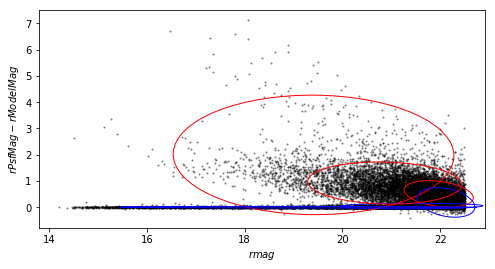

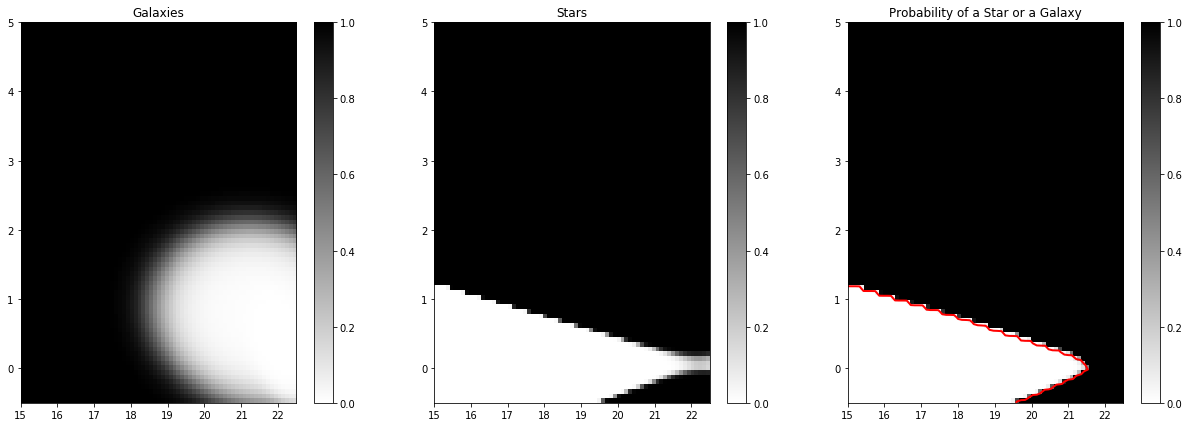

In [32]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

from astroML.datasets import fetch_imaging_sample

from sklearn.mixture import GaussianMixture
from astroML.plotting.tools import draw_ellipse

#----------------------------------------------------------------------
# get data: returns data and classification (0:star / 1:RR Lyrae)
# data are u-g, g-r, r-i, i-z
#X, y = fetch_rrlyrae_combined()
# get data: returns data and classification (0:star / 1:galaxy)

def get_stars_and_galaxies(Nstars=10000, Ngals=10000):
    """Get the subset of star/galaxy data to plot"""
    data = fetch_imaging_sample()
    objtype = data['type']
    stars = data[objtype == 6][:Nstars]
    galaxies = data[objtype == 3][:Ngals]
    return np.concatenate([stars,galaxies]), np.concatenate([np.zeros(len(stars)),np.ones(len(galaxies))])


data, y = get_stars_and_galaxies(Nstars=10000, Ngals=10000)

# select r model mag and psf - model mag as columns
X = np.column_stack((data['rRaw'], data['rRawPSF'] - data['rRaw']))

n_components = 3

clfGalaxies = GaussianMixture(n_components, max_iter=100, 
                          init_params='random', random_state=10)
clfStars = GaussianMixture(n_components, max_iter=100, 
                          init_params='random', random_state=10)


# Fit galaxies given each class
clfGalaxies.fit(X[:, [0, 1]][y==1])
clfStars.fit(X[:, [0, 1]][y==0])

# Plot results
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)

ax.scatter(X[:,[0]], X[:,[1]], c='k', s=4, alpha=0.5, lw=0, cmap=plt.cm.binary)
xlim = (15., 22.5)
ylim = (-0.5, 5.)
ax.set_xlabel('$r mag$')
ax.set_ylabel('$rPsfMag - rModelMag$')

# plot the components
for i in range(clfGalaxies.n_components):
    draw_ellipse(clfGalaxies.means_[i], clfGalaxies.covariances_[i], ax=ax, fc='none', ec='r', zorder=2, scales=[2])
    draw_ellipse(clfStars.means_[i], clfStars.covariances_[i], ax=ax, fc='none', ec='b', zorder=2, scales=[2])
   

### Classification tools

astroML and scikit-learn have many  example applications that can be used to classify data. These include fitting to data, estimating the probabilites, and applying these probabilities to a new (test) sample.

Some approaches are Bayesian (see A497), others are based on Maximum-Likelihood estimates. Some search for a boundary that separates two (or more) populations and others express a classification in terms of a probability

Most of the approachs use the same API we found in our regression and density estimation work.

We define the classifier we are interested in (e.g. `clf = GaussianNB()` for a Naive Bayes Gaussian classifier)

We fit the model using the training data with `clf.fit(X, y)`

We predict the classes for a set of data (or points on a grid) with `clf.predict()`


### Naive Bayes

For a classification in all its complexity we want the density $p(x_1,x_2,x_3...x_n|y)$. Making the assumption that all attributes are conditionally
independent reduces the dimensionality as   

$ p(x^i,x^j|y_k) = p(x^i|y)p(x^j|y_k)$
  
which can be written as

$ p({x^0,x^1,x^2,\ldots,x^N}|y_k) = \prod_i p(x^i|y_k)$

Naive Bayes estimates these probabilities. In Gaussian naive Bayes $p_k(x^i)$ are modeled as  one-dimensional Normal distributions, with means $\mu^i_k$ and widths $\sigma^i_k$. 

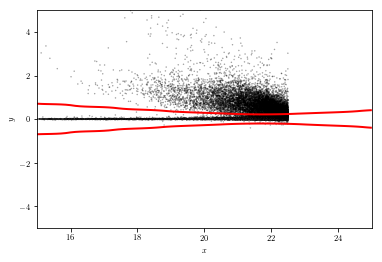

In [47]:
%matplotlib inline

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general


import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

from astroML.datasets import fetch_imaging_sample

from sklearn.mixture import GMM
from astroML.plotting.tools import draw_ellipse
from sklearn.naive_bayes import GaussianNB


def get_stars_and_galaxies(Nstars=10000, Ngals=10000):
    """Get the subset of star/galaxy data to plot"""
    data = fetch_imaging_sample()

    objtype = data['type']

    stars = data[objtype == 6][:Nstars]
    
    galaxies = data[objtype == 3][:Ngals]

    return np.concatenate([stars,galaxies]), np.concatenate([np.zeros(len(stars)),np.ones(len(galaxies))])

data, y = get_stars_and_galaxies(Nstars=10000, Ngals=10000)

# select r model mag and psf - model mag as columns
X = np.column_stack((data['rRaw'], data['rRawPSF'] - data['rRaw']))

#------------------------------------------------------------
# Fit the Naive Bayes classifier
clf = GaussianNB()
clf.fit(X, y)

# predict the classification probabilities on a grid
xlim = (15, 25)
ylim = (-5, 5)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#------------------------------------------------------------
# Plot the contour that corresponds to the line where stars and galaxies are equally likely
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary, zorder=2, alpha=0.4, s=0.2)

ax.contour(xx, yy, Z, [0.5], linewidths=2., colors='red')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()


### Linear discriminant analysis

Linear discriminant analysis (LDA) assumes  the class distributions have identical
covariances for all $K$ classes (all classes are a set of shifted Gaussians). 

The discriminant boundary between classes is the line that minimizes
the overlap between Gaussians. For `LinearDiscriminantAnalysis` we define the class, fit the data, and predict the classifications for the test data in three easy steps.

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])



`clf.predict` will predict the class for an object given a data set.

astroML has a couple of interesting helper functions

`split_samples(X, y,[0.75, 0.25],random_state=0)` will randomly split a data set into two subsets (a test and training sample). For this example the training set has 75% of the data and the test sample 25%

`completeness_contamination(predictions, y_test)` will take the labeled data and the predicted classifications (using the test data set) and calculate the completeness and contamination of the test

completeness [0.48175182 0.67153285 0.67153285 0.67153285]
contamination [0.85300668 0.80590717 0.80467091 0.80590717]


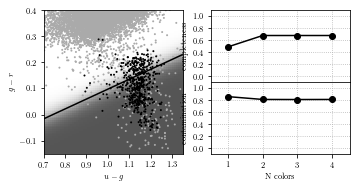

In [48]:
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform LinearDiscriminantAnalysis
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

for nc in Ncolors:
    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6, label='unweighted')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6, label='unweighted')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')

ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

### GMM and Bayesian classification

The natural extension to the Gaussian assumptions in out Naive Bayes classifier is to use GMMs to learn the density distribution. The number of Gaussian components $K$ must be chosen for each class independently



@pickle_results: using precomputed results from 'GMMbayes_rrlyrae.pkl'
completeness [[0.48175182 0.68613139 0.73722628 0.78832117]
 [0.         0.12408759 0.3649635  0.68613139]]
contamination [[0.85201794 0.79249448 0.77605322 0.75675676]
 [0.         0.22727273 0.10714286 0.2295082 ]]


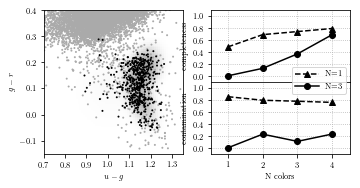

In [50]:
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from astroML.classification import GMMBayes
from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results

# GMM-bayes takes several minutes to run, and is order[N^2]
#  truncating the dataset can be useful for experimentation.
#X = X[::10]
#y = y[::10]

(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)
N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform GMM Bayes
Ncolors = np.arange(1, X.shape[1] + 1)
Ncomp = [1, 3]


@pickle_results('GMMbayes_rrlyrae.pkl')
def compute_GMMbayes(Ncolors, Ncomp):
    classifiers = []
    predictions = []

    for ncm in Ncomp:
        classifiers.append([])
        predictions.append([])
        for nc in Ncolors:
            clf = GMMBayes(ncm,  covariance_type='full')
            clf.fit(X_train[:, :nc], y_train)
            y_pred = clf.predict(X_test[:, :nc])

            classifiers[-1].append(clf)
            predictions[-1].append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_GMMbayes(Ncolors, Ncomp)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness[0], '^--k', ms=6, label='N=%i' % Ncomp[0])
ax.plot(Ncolors, completeness[1], 'o-k', ms=6, label='N=%i' % Ncomp[1])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], '^--k', ms=6, label='N=%i' % Ncomp[0])
ax.plot(Ncolors, contamination[1], 'o-k', ms=6, label='N=%i' % Ncomp[1])
ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.78))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

**K-nearest neighbours**

As with density estimation (and kernel density estimation)  the intuitive
justification is that $p(y|x) \approx p(y|x')$ if $x'$ is very
close to $x$.  

The number of neighbors, $K$,
regulates the complexity of the
classification. In its simplest form, a majority rule classification is adopted, where
each of the $K$ points votes on the classification.
Increasing $K$
decreases the variance in the classification but at the expense of an
increase in the bias.  

Weights can be assigned to  individual votes by weighting the vote by the
distance to the nearest point.

completeness [[0.22627737 0.3649635  0.46715328 0.54014599]
 [0.00729927 0.23357664 0.40145985 0.53284672]]
contamination [[0.78014184 0.53271028 0.44347826 0.41732283]
 [0.875      0.44827586 0.24657534 0.23958333]]


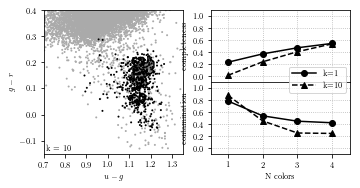

In [51]:
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

from sklearn.neighbors import KNeighborsClassifier
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform Classification

classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
kvals = [1, 10]

for k in kvals:
    classifiers.append([])
    predictions.append([])
    for nc in Ncolors:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 2)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

ax.text(0.02, 0.02, "k = %i" % kvals[1],
        transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)

ax.plot(Ncolors, completeness[0], 'o-k', ms=6, label='k=%i' % kvals[0])
ax.plot(Ncolors, completeness[1], '^--k', ms=6, label='k=%i' % kvals[1])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], 'o-k', ms=6, label='k=%i' % kvals[0])
ax.plot(Ncolors, contamination[1], '^--k', ms=6, label='k=%i' % kvals[1])
ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.79))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

### Decision Trees

The hierarchical application of decision boundaries lead to _decision trees_

Tree structure:

*  top node contains the entire data set
*  at each branch the data are subdivided into two child nodes 
*  split is based on a predefined decision boundary (usually axis aligned)
*  splitting repeats, recursively, until we reach a predefined stopping criteria 

<img src="decision.png">

The "leaf nodes"record the fraction of points that have one classification or the other

Application of the tree to classification is simple (a series of binary decisions). The  fraction of points from the training set classified as one class or the other (in the leaf node) defines the class
associated with that leaf node.

Decision trees are simple to interpret (a set of questions)

completeness [[0.00729927 0.3649635  0.29927007 0.62773723]
 [0.02189781 0.31386861 0.51824818 0.57664234]]
contamination [[0.66666667 0.375      0.31666667 0.31746032]
 [0.625      0.48809524 0.37719298 0.3875969 ]]


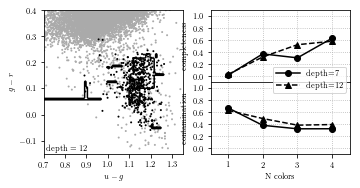

In [52]:
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)
N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# Fit Decision tree
Ncolors = np.arange(1, X.shape[1] + 1)

classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
depths = [7, 12]

for depth in depths:
    classifiers.append([])
    predictions.append([])
    for nc in Ncolors:
        clf = DecisionTreeClassifier(random_state=0, max_depth=depth,
                                     criterion='entropy')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# compute the decision boundary

clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101),
                     np.linspace(ylim[0], ylim[1], 101))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

ax.text(0.02, 0.02, "depth = %i" % depths[1],
        transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness[0], 'o-k', ms=6, label="depth=%i" % depths[0])
ax.plot(Ncolors, completeness[1], '^--k', ms=6, label="depth=%i" % depths[1])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], 'o-k', ms=6, label="depth=%i" % depths[0])
ax.plot(Ncolors, contamination[1], '^--k', ms=6, label="depth=%i" % depths[1])
ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.79))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

### Wrapping it up

scikit-learn and astroML have a very broad range of applications with simple interfaces for classifying, fitting, and modeling data